### Import Required Libraries

In [ ]:
# import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers

# import other libraries
import string
import numpy as np
import re
from numpy import array, argmax, random, take
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'Monitorías Tópicos Avanzados en Inteligencia Artificial I/WorkShop 8'
print(base_dir)

Mounted at /content/drive
/content/drive/My Drive/Monitorías Tópicos Avanzados en Inteligencia Artificial I/WorkShop 8


### Read Data

Our data is a text file of English-Spanish parallel sentence pairs corpora. First we will read the file using the function defined below.

In [ ]:
import os
# function to read raw text file
#filename = os.path.join(base_dir, spa.txt)
def read_text(filename):
    # open the file
    file = open(os.path.join(base_dir, filename), mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text
data = read_text("spa.txt")

Now let's define a function to split the text into English-Spanish pairs separated by '\n' and then split these pairs into English sentences and Spanish sentences.

In [ ]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download other parallel corpora data from [here.](http://www.manythings.org/anki/)__ You can download "deu.txt" (german to english) in your working directory.

In [ ]:
data = read_text("spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)
print(len(spa_eng))  # what is the number of lines of this file?

128084


The actual data contains over 128,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [ ]:
spa_eng = spa_eng[:50000,:]
print(spa_eng)
print(len(spa_eng))

[['Go.' 'Ve.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)']
 ['Go.' 'Vete.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)']
 ['Go.' 'Vaya.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)']
 ...
 ['Please turn off the radio.' 'Por favor, apague la radio.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)']
 ['Please turn off the radio.' 'Apagá la radio, por favor.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)']
 ['Please wake me up at 6:30.'
  'Por favor despiértame a las seis y media.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']]
50000


### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [ ]:
spa_eng

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Please turn off the radio.', 'Por favor, apague la radio.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)'],
       ['Please turn off the radio.', 'Apagá la radio, por favor.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)'],
       ['Please wake me up at 6:30.',
        'Por favor despiértame a las seis y media.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']],
      dtype='<U278')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [ ]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [ ]:
spa_eng

array([['Go', 'Ve',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go', 'Vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go', 'Vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['Please turn off the radio', 'Por favor apague la radio',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)'],
       ['Please turn off the radio', 'Apagá la radio por favor',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)'],
       ['Please wake me up at 630',
        'Por favor despiértame a las seis y media',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']],
      dtype='<U278')

In [ ]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()  # sending over lowercase

In [ ]:
spa_eng

array([['go', 've',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['go', 'vete',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['go', 'vaya',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ['please turn off the radio', 'por favor apague la radio',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1198501 (cueyayotl)'],
       ['please turn off the radio', 'apagá la radio por favor',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1197303 (waeltken) & #1215556 (El_mas_capo)'],
       ['please wake me up at 630',
        'por favor despiértame a las seis y media',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2429736 (CK) & #2429789 (kuma)']],
      dtype='<U278')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model (By Google, the initial one !), we will have to convert both the input and the output sentences into integer sequences of __fixed length__. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and Spanish (German for the WorkShop), respectively.

In [ ]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [ ]:
#from pandas.core.arrays.datetimes import DataFrame
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
length_df.head(5)

,eng,spa
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


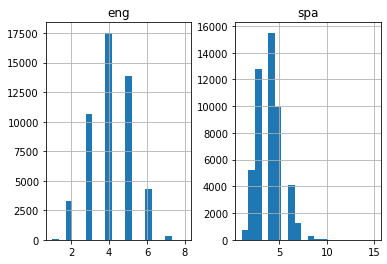

In [ ]:
length_df.hist(bins = 20)
plt.show()

The maximum length of the English sentences is 8 and that of the English phrases is 10.

Let's vectorize our text data by using Keras' Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6861


In [ ]:
# prepare Spanish - Deutch tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
#deu_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)
#print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Spanish Vocabulary Size: 14058


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.1, random_state = 12)

It's time to encode the sentences. We will encode Spanish (German) sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [ ]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [ ]:
# build NMT model (encoder-decoder)  Remember the U-Net for images, the same rationale !
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))

    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping (manually pick the model with the less distance between train and valid loss).

In [ ]:
epochs = 30
batch_size = 512

In [ ]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=epochs, batch_size=batch_size, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
70/71 [============================>.] - ETA: 0s - loss: 3.7914
Epoch 1: val_loss improved from inf to 3.23410, saving model to model.h1.24_jan_19


71/71 [==============================] - 30s 289ms/step - loss: 3.7889 - val_loss: 3.2341
Epoch 2/30
70/71 [============================>.] - ETA: 0s - loss: 3.1425
Epoch 2: val_loss improved from 3.23410 to 3.10852, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 245ms/step - loss: 3.1423 - val_loss: 3.1085
Epoch 3/30
70/71 [============================>.] - ETA: 0s - loss: 2.9759
Epoch 3: val_loss improved from 3.10852 to 2.95332, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 250ms/step - loss: 2.9754 - val_loss: 2.9533
Epoch 4/30
70/71 [============================>.] - ETA: 0s - loss: 2.8192
Epoch 4: val_loss improved from 2.95332 to 2.81930, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 250ms/step - loss: 2.8194 - val_loss: 2.8193
Epoch 5/30
70/71 [============================>.] - ETA: 0s - loss: 2.6491
Epoch 5: val_loss improved from 2.81930 to 2.67871, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 244ms/step - loss: 2.6490 - val_loss: 2.6787
Epoch 6/30
70/71 [============================>.] - ETA: 0s - loss: 2.4863
Epoch 6: val_loss improved from 2.67871 to 2.57621, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 246ms/step - loss: 2.4858 - val_loss: 2.5762
Epoch 7/30
70/71 [============================>.] - ETA: 0s - loss: 2.3285
Epoch 7: val_loss improved from 2.57621 to 2.45740, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 244ms/step - loss: 2.3287 - val_loss: 2.4574
Epoch 8/30
70/71 [============================>.] - ETA: 0s - loss: 2.1827
Epoch 8: val_loss improved from 2.45740 to 2.35011, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 256ms/step - loss: 2.1824 - val_loss: 2.3501
Epoch 9/30
70/71 [============================>.] - ETA: 0s - loss: 2.0480
Epoch 9: val_loss improved from 2.35011 to 2.26666, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 246ms/step - loss: 2.0476 - val_loss: 2.2667
Epoch 10/30
70/71 [============================>.] - ETA: 0s - loss: 1.9232
Epoch 10: val_loss improved from 2.26666 to 2.18664, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 249ms/step - loss: 1.9233 - val_loss: 2.1866
Epoch 11/30
70/71 [============================>.] - ETA: 0s - loss: 1.8096
Epoch 11: val_loss improved from 2.18664 to 2.11012, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 243ms/step - loss: 1.8095 - val_loss: 2.1101
Epoch 12/30
70/71 [============================>.] - ETA: 0s - loss: 1.7016
Epoch 12: val_loss improved from 2.11012 to 2.04827, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 243ms/step - loss: 1.7016 - val_loss: 2.0483
Epoch 13/30
70/71 [============================>.] - ETA: 0s - loss: 1.5974
Epoch 13: val_loss improved from 2.04827 to 2.00377, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 245ms/step - loss: 1.5974 - val_loss: 2.0038
Epoch 14/30
70/71 [============================>.] - ETA: 0s - loss: 1.4991
Epoch 14: val_loss improved from 2.00377 to 1.95599, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 247ms/step - loss: 1.4988 - val_loss: 1.9560
Epoch 15/30
70/71 [============================>.] - ETA: 0s - loss: 1.4040
Epoch 15: val_loss improved from 1.95599 to 1.91391, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 243ms/step - loss: 1.4040 - val_loss: 1.9139
Epoch 16/30
70/71 [============================>.] - ETA: 0s - loss: 1.3155
Epoch 16: val_loss improved from 1.91391 to 1.89705, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 256ms/step - loss: 1.3155 - val_loss: 1.8970
Epoch 17/30
70/71 [============================>.] - ETA: 0s - loss: 1.2285
Epoch 17: val_loss improved from 1.89705 to 1.84328, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 254ms/step - loss: 1.2285 - val_loss: 1.8433
Epoch 18/30
70/71 [============================>.] - ETA: 0s - loss: 1.1465
Epoch 18: val_loss improved from 1.84328 to 1.79248, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 247ms/step - loss: 1.1469 - val_loss: 1.7925
Epoch 19/30
70/71 [============================>.] - ETA: 0s - loss: 1.0690
Epoch 19: val_loss did not improve from 1.79248
71/71 [==============================] - 5s 67ms/step - loss: 1.0692 - val_loss: 1.7959
Epoch 20/30
70/71 [============================>.] - ETA: 0s - loss: 0.9963
Epoch 20: val_loss improved from 1.79248 to 1.74120, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 248ms/step - loss: 0.9960 - val_loss: 1.7412
Epoch 21/30
70/71 [============================>.] - ETA: 0s - loss: 0.9264
Epoch 21: val_loss improved from 1.74120 to 1.73102, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 246ms/step - loss: 0.9263 - val_loss: 1.7310
Epoch 22/30
70/71 [============================>.] - ETA: 0s - loss: 0.8607
Epoch 22: val_loss improved from 1.73102 to 1.72932, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 247ms/step - loss: 0.8605 - val_loss: 1.7293
Epoch 23/30
70/71 [============================>.] - ETA: 0s - loss: 0.7956
Epoch 23: val_loss improved from 1.72932 to 1.70347, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 246ms/step - loss: 0.7956 - val_loss: 1.7035
Epoch 24/30
70/71 [============================>.] - ETA: 0s - loss: 0.7380
Epoch 24: val_loss improved from 1.70347 to 1.69475, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 259ms/step - loss: 0.7380 - val_loss: 1.6947
Epoch 25/30
70/71 [============================>.] - ETA: 0s - loss: 0.6825
Epoch 25: val_loss improved from 1.69475 to 1.67225, saving model to model.h1.24_jan_19


71/71 [==============================] - 18s 249ms/step - loss: 0.6824 - val_loss: 1.6723
Epoch 26/30
70/71 [============================>.] - ETA: 0s - loss: 0.6294
Epoch 26: val_loss improved from 1.67225 to 1.66208, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 246ms/step - loss: 0.6294 - val_loss: 1.6621
Epoch 27/30
70/71 [============================>.] - ETA: 0s - loss: 0.5821
Epoch 27: val_loss did not improve from 1.66208
71/71 [==============================] - 5s 67ms/step - loss: 0.5819 - val_loss: 1.6621
Epoch 28/30
70/71 [============================>.] - ETA: 0s - loss: 0.5344
Epoch 28: val_loss did not improve from 1.66208
71/71 [==============================] - 5s 66ms/step - loss: 0.5343 - val_loss: 1.6761
Epoch 29/30
70/71 [============================>.] - ETA: 0s - loss: 0.4921
Epoch 29: val_loss improved from 1.66208 to 1.64693, saving model to model.h1.24_jan_19


71/71 [==============================] - 17s 243ms/step - loss: 0.4923 - val_loss: 1.6469
Epoch 30/30
70/71 [============================>.] - ETA: 0s - loss: 0.4503
Epoch 30: val_loss did not improve from 1.64693
71/71 [==============================] - 5s 67ms/step - loss: 0.4503 - val_loss: 1.6650


Let's compare the training loss and the validation loss.

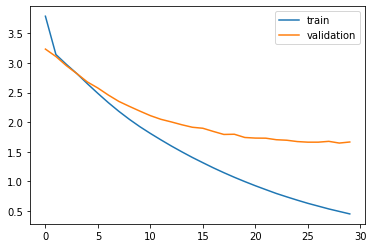

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [ ]:
preds = model.predict(testX).astype('float16')
preds = np.argmax(preds, axis=-1)

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if ((t == get_word(i[j-1], eng_tokenizer)) or (t == None)):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'spanish' : test[:,1], 'actual' : test[:,0]})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,predicted,spanish,actual
0,i asked you to stay me,les pedí que me llamaran,i asked you to call me
1,hes is,él es dj,he is a dj
2,they approve,ellos discutieron,they quarreled
3,im not afraid,no tengo miedo,im not scared
4,im ready to you,estoy listo para seguirte,i am ready to follow you
5,please the phone,por favor coge el teléfono,please answer the phone
6,she told him to the,le dijo adiós con la mano,she waved goodbye to him
7,the car was impounded,el carro de tom fue confiscado,toms car was impounded
8,dont make on left,no ponga excusas,dont make excuses
9,you must to be polite,tienen que ser más respetuosos,you must be more polite


In [ ]:
pred_df.tail(15)

,predicted,spanish,actual
4985,please dont cry again,por favor no llores de nuevo,please dont cry again
4986,id like to see a doctor,quisiera ver a un doctor,id like to see a doctor
4987,my hair is,mi empresa tiene éxito,my company is successful
4988,can tom call tom,¿puedes encontrar a tom por mí,can you find tom for me
4989,im going my,voy a tener mi venganza,ill have my revenge
4990,i got a lot,me divertí,i had some fun
4991,boston is a city,tokio es una gran ciudad,tokyo is a big city
4992,he has a small,tiene un cuello muy largo,he has a long neck
4993,tom is waiting,tom está esperando,tom is waiting
4994,i wasnt worried,no fui preocupado,i wasnt careful


In [ ]:
pred_df.sample(15)

,predicted,spanish,actual
221,i cant give up,no puedo levantarme,i cant stand up
1174,he was very serious,él también era muy serio,he also was very serious
739,arent you kidding,¿no estás bromeando,are you serious
2947,your is,tráete a tu amigo,bring along your friend
3440,you are,estás detenido,youre under arrest
3393,tom was in the audience,tom estaba en la cabaña,tom was in the cabin
2760,i have my sunglasses,tengo todo el cuerpo dolorido,my whole body is sore
2839,the night was wet,el aterrizaje fue perfecto,the landing was perfect
4655,toms life is canadian,el jefe de tom es canadiense,toms boss is canadian
1773,i saw tom play tennis,vi a tom jugar al tenis,i saw tom play tennis
